In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [14]:
data = pd.read_csv('../results/cleaned_data.csv')
data.head()

,timestamp,user_id,day,quiz_id,image_index,illusion_filename,user_answer,response_time,speed_group,display_time,correct_answer,line_length1,line_length2,actual_difference,arrow_length,angle,arrow_color,is_control,is_correct
0,2024-11-05 01:34:15,Haleygundie,1,1,0,muller_lyer_day1_illusion13.svg,Left,7.209,Group 1 - Slow,5.0,Right,185,200,-15,20,36,black,False,False
1,2024-11-05 01:34:22,Haleygundie,1,1,1,muller_lyer_day1_illusion27.svg,Same length,5.427,Group 1 - Slow,5.0,Same length,200,200,0,20,36,red,False,True
2,2024-11-05 01:34:27,Haleygundie,1,1,2,muller_lyer_day1_illusion46.svg,Left,4.179,Group 1 - Slow,5.0,Left,205,180,25,20,36,red,False,True
3,2024-11-05 01:34:35,Haleygundie,1,1,3,muller_lyer_day1_illusion37.svg,Right,6.192,Group 1 - Slow,5.0,Right,185,200,-15,20,36,red,False,True
4,2024-11-05 01:34:41,Haleygundie,1,1,4,muller_lyer_day1_illusion42.svg,Right,5.236,Group 1 - Slow,5.0,Right,185,220,-35,20,36,red,False,True


Data distribution across groups:
main_group  speed_condition
Group 1     Fast               2164
            Slow               1394
Group 2     Fast               1098
            Slow               1048
dtype: int64

Metrics Summary:
  main_group speed_condition day_type  accuracy  response_time  n_trials  \
0    Group 1            Fast    First  0.520833       2.335236       144   
1    Group 1            Fast     Last  0.375000       1.456625        48   
2    Group 1            Slow    First  0.562500       3.598174       144   
3    Group 1            Slow     Last  0.375000       1.933833        48   
4    Group 2            Fast    First  0.541667       2.233417        48   
5    Group 2            Fast     Last  0.620000       1.694340        50   
6    Group 2            Slow    First  0.460000       3.264720        50   
7    Group 2            Slow     Last  0.780000       2.202820        50   

   std_accuracy    std_rt  
0      0.501309  1.000942  
1      0.489246  1.0761

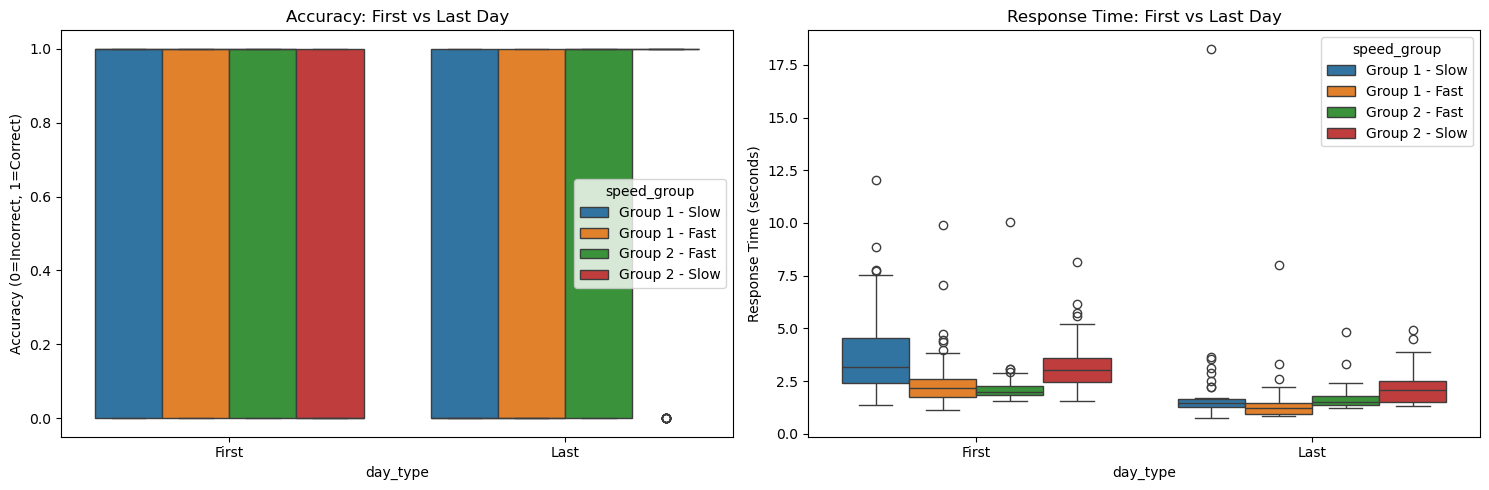

In [15]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_group_performance(df):
    # Convert is_correct to numeric (1 for True, 0 for False)
    df['is_correct_numeric'] = df['is_correct'].astype(int)
    
    # Create group identifier
    df['main_group'] = df['speed_group'].str.split(' - ').str[0]
    df['speed_condition'] = df['speed_group'].str.split(' - ').str[1]
    
    # Print data validation
    print("Data distribution across groups:")
    print(df.groupby(['main_group', 'speed_condition']).size())
    
    # Get first and last days overall
    first_day = df['day'].min()
    last_day = df['day'].max()
    
    # Filter for first and last days
    first_last_data = df[df['day'].isin([first_day, last_day])].copy()
    first_last_data['day_type'] = first_last_data['day'].map({first_day: 'First', last_day: 'Last'})
    
    # Calculate metrics for each group and condition
    metrics = []
    for group in ['Group 1', 'Group 2']:
        for speed in ['Fast', 'Slow']:
            for day_type in ['First', 'Last']:
                mask = ((first_last_data['main_group'] == group) & 
                       (first_last_data['speed_condition'] == speed) & 
                       (first_last_data['day_type'] == day_type))
                
                group_data = first_last_data[mask]
                
                if len(group_data) > 0:
                    metrics.append({
                        'main_group': group,
                        'speed_condition': speed,
                        'day_type': day_type,
                        'accuracy': group_data['is_correct_numeric'].mean(),
                        'response_time': group_data['response_time'].mean(),
                        'n_trials': len(group_data),
                        'std_accuracy': group_data['is_correct_numeric'].std(),
                        'std_rt': group_data['response_time'].std()
                    })
    
    metrics_df = pd.DataFrame(metrics)
    
    # Statistical tests
    stats_results = {}
    for group in ['Group 1', 'Group 2']:
        group_data = first_last_data[first_last_data['main_group'] == group]
        
        # Accuracy
        first_acc = group_data[group_data['day_type'] == 'First']['is_correct_numeric']
        last_acc = group_data[group_data['day_type'] == 'Last']['is_correct_numeric']
        if len(first_acc) > 0 and len(last_acc) > 0:
            acc_ttest = stats.ttest_ind(first_acc, last_acc)
            stats_results[f'{group}_accuracy'] = acc_ttest
        
        # Response Time
        first_rt = group_data[group_data['day_type'] == 'First']['response_time']
        last_rt = group_data[group_data['day_type'] == 'Last']['response_time']
        if len(first_rt) > 0 and len(last_rt) > 0:
            rt_ttest = stats.ttest_ind(first_rt, last_rt)
            stats_results[f'{group}_rt'] = rt_ttest
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy plot
    sns.boxplot(data=first_last_data, x='day_type', y='is_correct_numeric', 
                hue='speed_group', ax=ax1)
    ax1.set_title('Accuracy: First vs Last Day')
    ax1.set_ylabel('Accuracy (0=Incorrect, 1=Correct)')
    
    # Response time plot
    sns.boxplot(data=first_last_data, x='day_type', y='response_time', 
                hue='speed_group', ax=ax2)
    ax2.set_title('Response Time: First vs Last Day')
    ax2.set_ylabel('Response Time (seconds)')
    
    plt.tight_layout()
    
    return {
        'metrics': metrics_df,
        'stats': stats_results,
        'plot': fig
    }


results = analyze_group_performance(data)

# Print results
print("\nMetrics Summary:")
print(results['metrics'])

print("\nStatistical Tests:")
for test_name, test_result in results['stats'].items():
    print(f"\n{test_name}:")
    print(f"t-statistic: {test_result.statistic:.3f}")
    print(f"p-value: {test_result.pvalue:.3f}")

# plt.show()